# 05 – Evaluation Metrics for the Semantic Scientific Paper Recommender

This notebook:
- Loads the FAISS index and the cleaned dataset
- Defines evaluation metrics (Precision@K, Recall@K, AUC)
- Creates a small test set of queries and relevant papers
- Computes retrieval performance and plots results

In [ ]:
import os
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math


from dotenv import load_dotenv
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

load_dotenv()
OPENAI_API_KEY = os.getenv("OPENAI_API_KEY")
assert OPENAI_API_KEY, "Please set OPENAI_API_KEY in .env"

# Paths
DATA_PATH = "../data/clean_papers.csv"
FAISS_PATH = "../data/faiss_index"
EMBEDDING_MODEL = "text-embedding-3-small"

# Settings
TOP_K = 10
NUM_QUERIES = 20   # number of random topics to test

In [2]:
df = pd.read_csv(DATA_PATH)
print("Loaded dataset:", df.shape)

embeddings = OpenAIEmbeddings(model=EMBEDDING_MODEL, api_key=OPENAI_API_KEY)
vectorstore = FAISS.load_local(
    FAISS_PATH, embeddings, allow_dangerous_deserialization=True
)
print("FAISS index loaded for evaluation.")

Loaded dataset: (136154, 9)
FAISS index loaded for evaluation.


Ground Truth:

We’ll approximate “relevance” using category codes or categories meaning that
two papers are relevant if they share the same category_code (or category).

In [3]:
def get_ground_truth(df, paper_id):
    """
    Return all other papers within the same broad 'category'
    (e.g., Computer Science) as relevant.
    """
    if paper_id not in df["id"].values:
        return set()

    cat = df.loc[df["id"] == paper_id, "category"].values[0]
    relevant_ids = df.loc[df["category"] == cat, "id"].tolist()

    if paper_id in relevant_ids:
        relevant_ids.remove(paper_id)

    return set(relevant_ids)

In [4]:
df["category"].value_counts().head(10)

category
Machine Learning                                          39965
Computer Vision and Pattern Recognition                   29049
Computation and Language (Natural Language Processing)    25196
Artificial Intelligence                                   12945
Machine Learning (Statistics)                             10430
Neural and Evolutionary Computing                          5508
Robotics                                                    903
Information Retrieval                                       901
Methodology (Statistics)                                    882
Optimization and Control                                    749
Name: count, dtype: int64

Evaluation Metrics

In [5]:
def precision_at_k(recommended, relevant, k):
    recommended_k = recommended[:k]
    return len(set(recommended_k) & relevant) / k


def auc_score(similarities, labels):
    """AUC over similarity vs relevance."""
    if len(set(labels)) == 1:
        return np.nan  # AUC undefined if all labels same
    return roc_auc_score(labels, similarities)

Evaluation Loop

In [6]:
def evaluate_model(df, vectorstore, num_queries=NUM_QUERIES, top_k=TOP_K):
    sampled_ids = random.sample(df["id"].tolist(), num_queries)
    results = []

    for pid in sampled_ids:
        query_row = df[df["id"] == pid].iloc[0]
        query_text = query_row["text"]
        relevant_ids = get_ground_truth(df, pid)
        if not relevant_ids:
            continue

        retrieved_docs = vectorstore.similarity_search_with_score(query_text, k=top_k)
        recommended_ids = [d.metadata["id"] for d, _ in retrieved_docs]
        similarities = [s for _, s in retrieved_docs]
        labels = [1 if rid in relevant_ids else 0 for rid in recommended_ids]

        prec = precision_at_k(recommended_ids, relevant_ids, top_k)
        auc = auc_score(similarities, labels)

        results.append({"id": pid, "precision@K": prec, "auc": auc})

    return pd.DataFrame(results)

metrics_df = evaluate_model(df, vectorstore)
metrics_df.head()

,id,precision@K,auc
0,abs-2203.00214v1,0.9,1.0000
1,abs-2003.12935v3,0.0,NaN
2,abs-1803.06521v2,0.8,0.6875
3,abs-1910.13732v1,0.9,1.0000
4,abs-2206.06247v1,0.2,0.1875


Average Precision@K: 62.00%
Average AUC: 72.04%


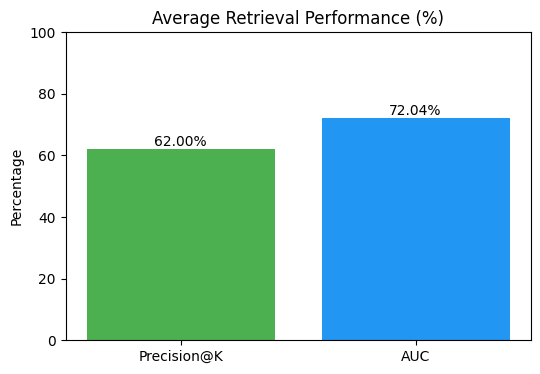

In [7]:
# Compute average metrics (as percentages)
avg_precision = metrics_df["precision@K"].mean() * 100
avg_auc = metrics_df["auc"].mean() * 100

print(f"Average Precision@K: {avg_precision:.2f}%")
print(f"Average AUC: {avg_auc:.2f}%")

import matplotlib.pyplot as plt

metrics_mean = {
    "Precision@K": metrics_df["precision@K"].mean() * 100,
    "AUC": metrics_df["auc"].mean() * 100,
}

plt.figure(figsize=(6, 4))
plt.bar(metrics_mean.keys(), metrics_mean.values(), color=["#4CAF50", "#2196F3", "#FFC107"])
plt.title("Average Retrieval Performance (%)")
plt.ylabel("Percentage")
plt.ylim(0, 100)
for i, v in enumerate(metrics_mean.values()):
    plt.text(i, v + 1, f"{v:.2f}%", ha="center")
plt.show()

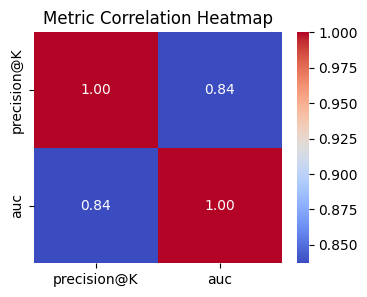

In [9]:
import seaborn as sns
plt.figure(figsize=(4,3))
sns.heatmap(metrics_df[["precision@K", "auc"]].corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Metric Correlation Heatmap")
plt.show()

In [ ]:
def rmse(y_true, y_pred):
    return math.sqrt(mean_squared_error(y_true, y_pred))

def mae(y_true, y_pred):
    return mean_absolute_error(y_true, y_pred)

rmse_values, mae_values = [], []

for pid in metrics_df["id"]:
    query_row = df[df["id"] == pid].iloc[0]
    query_text = query_row["text"]
    relevant_ids = get_ground_truth(df, pid)
    if not relevant_ids:
        continue

    retrieved_docs = vectorstore.similarity_search_with_score(query_text, k=TOP_K)
    similarities = [score for _, score in retrieved_docs]
    labels = [1 if d.metadata["id"] in relevant_ids else 0 for d, _ in retrieved_docs]

    if len(set(labels)) < 2:
        continue  # skip all-0 or all-1 cases

    rmse_values.append(rmse(labels, similarities))
    mae_values.append(mae(labels, similarities))

avg_rmse = np.mean(rmse_values)
avg_mae = np.mean(mae_values)

print(f"Average RMSE: {avg_rmse:.4f}")
print(f"Average MAE: {avg_mae:.4f}")

Average RMSE: 0.4152
Average MAE: 0.3819


In [11]:
import pandas as pd

# Compute average metrics (convert to percentages where appropriate)
avg_precision = metrics_df["precision@K"].mean() * 100
avg_auc = metrics_df["auc"].mean() * 100

# Combine with RMSE & MAE from previous step
summary_data = {
    "Metric": ["Precision@K", "AUC", "RMSE", "MAE"],
    "Average Value": [
        f"{avg_precision:.2f}%",
        f"{avg_auc:.2f}%",
        f"{avg_rmse:.4f}",
        f"{avg_mae:.4f}",
    ]
}

summary_table = pd.DataFrame(summary_data)
summary_table.style.set_properties(**{
    'background-color': '#f9f9f9',
    'color': '#333',
    'border-color': '#ddd',
    'text-align': 'center'
}).set_table_styles(
    [{'selector': 'th', 'props': [('background-color', '#4CAF50'), ('color', 'white'), ('font-weight', 'bold')]}]
)

,Metric,Average Value
0,Precision@K,62.00%
1,AUC,72.04%
2,RMSE,0.4152
3,MAE,0.3819
